In [7]:
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import os;

In [8]:
### LEGACY DATAFRAME PARSING FROM FILESYSTEM
## We assume that we have a results_total directory that contains one directory per device that run the test, which in turn contains a directory for every model with each type of coloring which contains the results
## Example ./results_total/my_pc/drawing_wedge_tex.ply/uber_flat_960x540.csv
#
#pth = "./results_total/"
#devices = os.listdir("./results_total/");
#dat = pd.DataFrame(columns=["Device","Mesh","Splitting","Shading","Coloring","Resolution","Framerates"]);
#for device in devices:
#    for mesh_unparsed in os.listdir(pth + device):
#        mesh = mesh_unparsed
#        coloring = ""
#        if(mesh.find("_col") != -1):
#            mesh = mesh.replace("_col", "")
#            coloring += "color"
#        if(mesh.find("_tex") != -1):
#            mesh = mesh.replace("_tex", "")
#            coloring += "texture"
#        if(mesh.find("_vert") != -1):
#            mesh = mesh.replace("_vert", "")
#            coloring = "vertex " + coloring
#        if(mesh.find("_face") != -1):
#            mesh = mesh.replace("_face", "")
#            coloring = "face " + coloring
#        if(mesh.find("_wedge") != -1):
#            mesh = mesh.replace("_wedge", "")
#            coloring = "wedge " + coloring
#        for csv_file in os.listdir(pth + device + "/" + mesh_unparsed):
#            splitting = ""
#            shading = ""
#            resolution = ""
#            framerates = []
#            for splits in ["uber", "split", "uber_static_if"]:
#                if csv_file.find(splits) != -1:
#                    splitting = splits
#            for shad in ["flat", "smooth"]:
#                if csv_file.find(shad) != -1:
#                    shading = shad
#            for res in ["960x540", "2560x1440"]:
#                if csv_file.find(res) != -1:
#                    resolution = res
#            with open(pth + device + "/" + mesh_unparsed + "/" + csv_file) as f:
#                file_string = f.read()
#                framerates = [float(x) for x in file_string.split("\n") if x!=""]
#            dat = pd.concat([dat, pd.DataFrame([[device,mesh,splitting,shading,coloring,resolution,framerates]], columns=dat.columns)], ignore_index=True)



        

In [9]:
dat = pd.read_json("./test_results.json")
print(dat)

                    Device            Mesh       Splitting Shading   Coloring  \
0          DESKTOP-GCGCTG4       myram.ply            uber    flat   col vert   
1          DESKTOP-GCGCTG4       myram.ply            uber    flat   col vert   
2          DESKTOP-GCGCTG4       myram.ply            uber    flat   col face   
3          DESKTOP-GCGCTG4       myram.ply            uber    flat   col face   
4          DESKTOP-GCGCTG4       myram.ply            uber    flat  tex wedge   
...                    ...             ...             ...     ...        ...   
1723  LAPTOP-LINUX-RTX3050  ESTE_PRINT.ply  uber_static_if  smooth   col vert   
1724  LAPTOP-LINUX-RTX3050  ESTE_PRINT.ply  uber_static_if  smooth   col face   
1725  LAPTOP-LINUX-RTX3050  ESTE_PRINT.ply  uber_static_if  smooth   col face   
1726  LAPTOP-LINUX-RTX3050  ESTE_PRINT.ply  uber_static_if  smooth  tex wedge   
1727  LAPTOP-LINUX-RTX3050  ESTE_PRINT.ply  uber_static_if  smooth  tex wedge   

     Resolution            

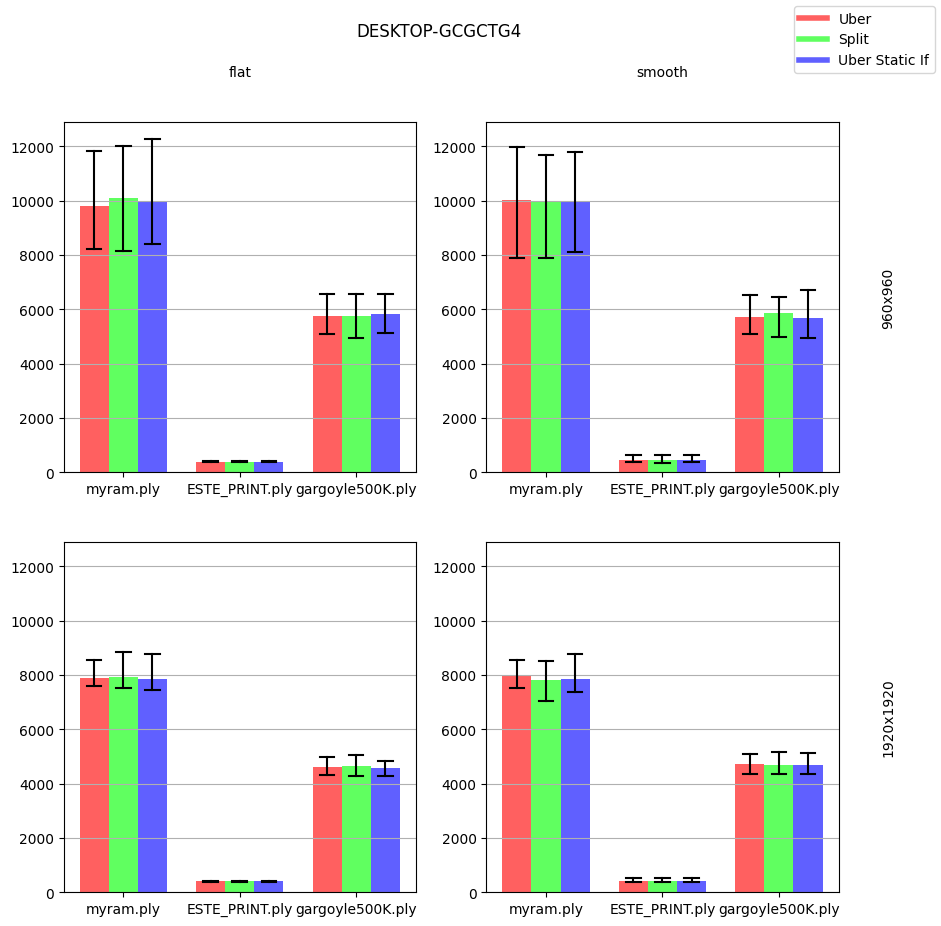

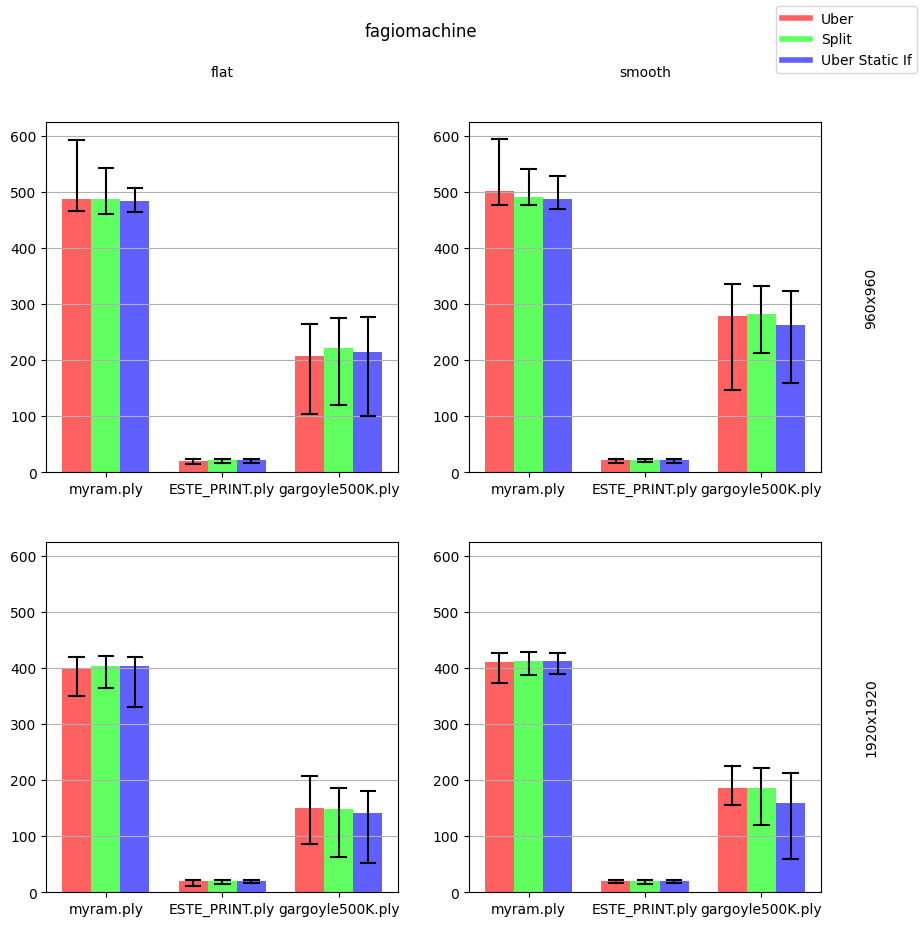

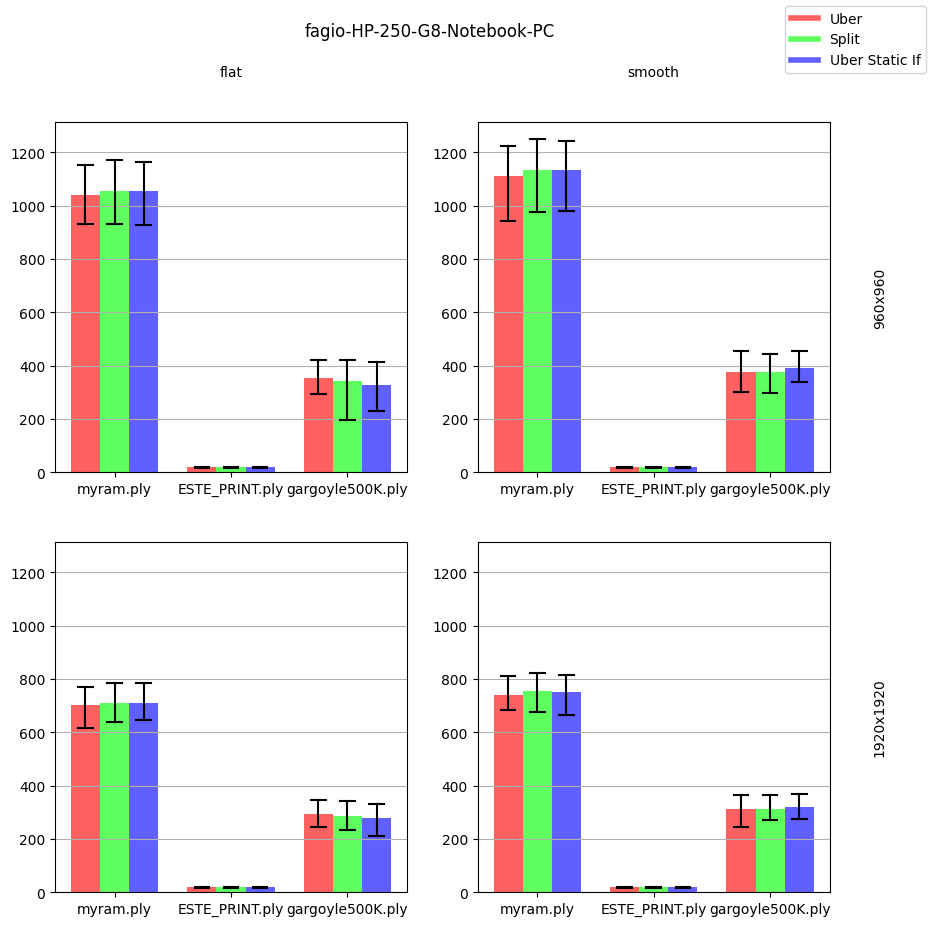

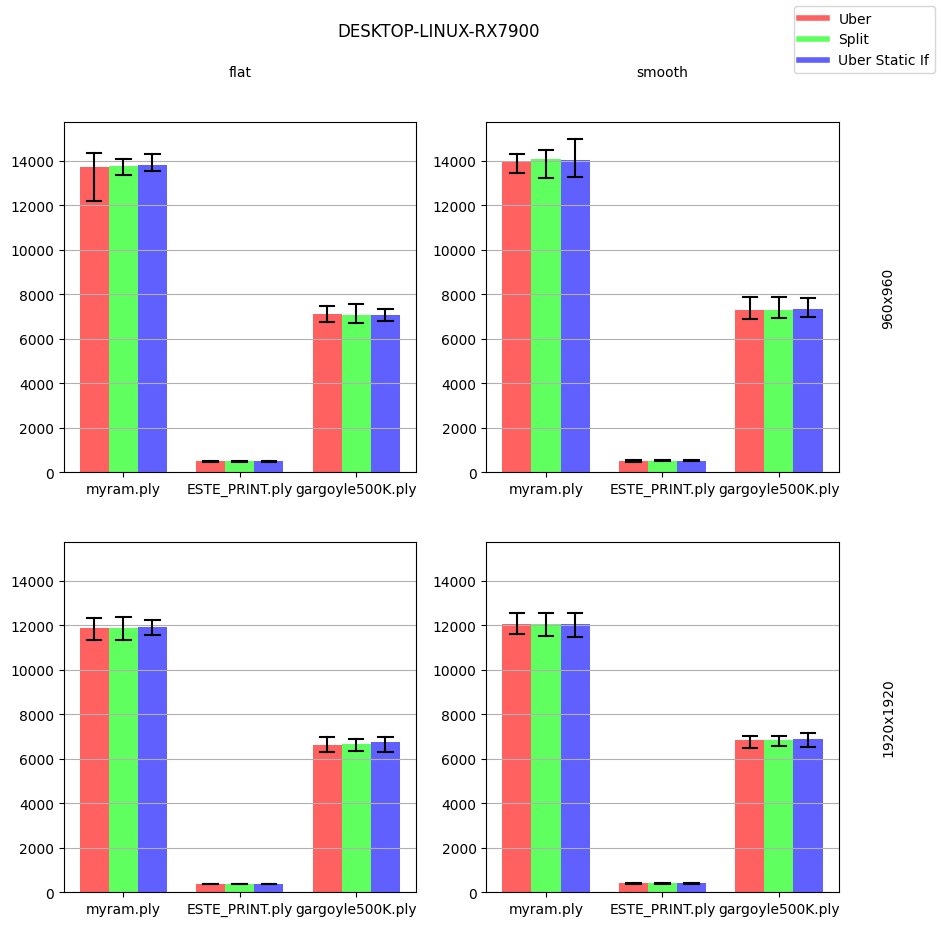

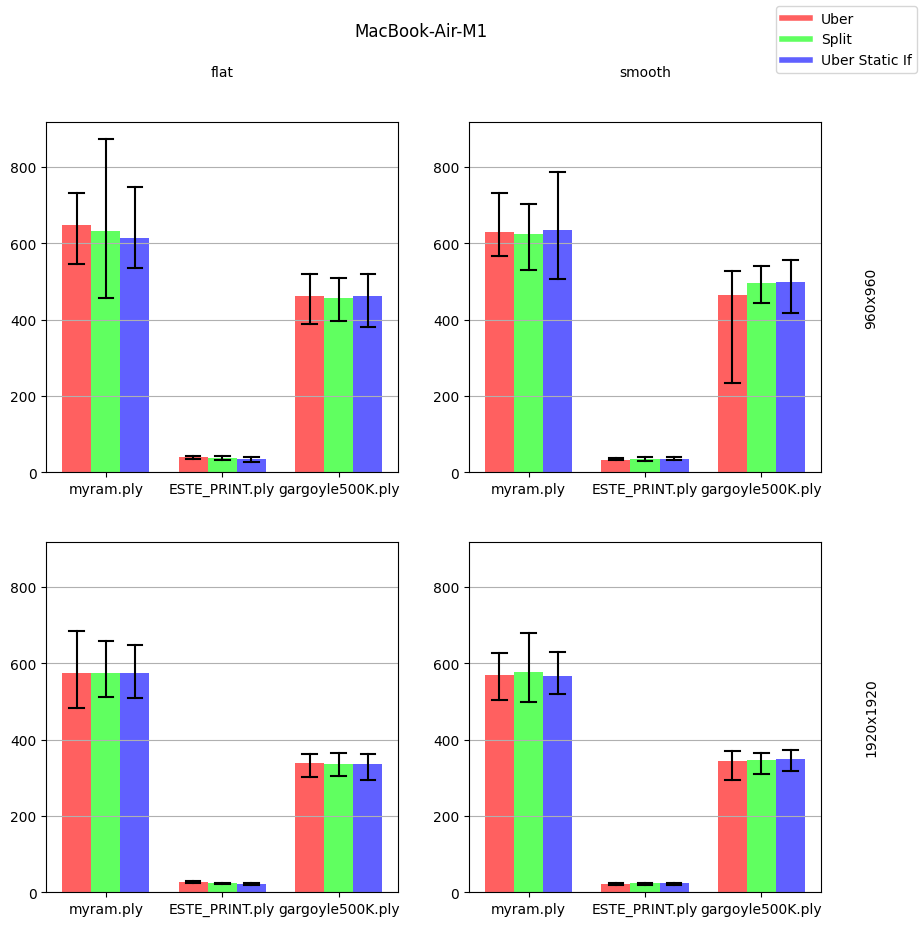

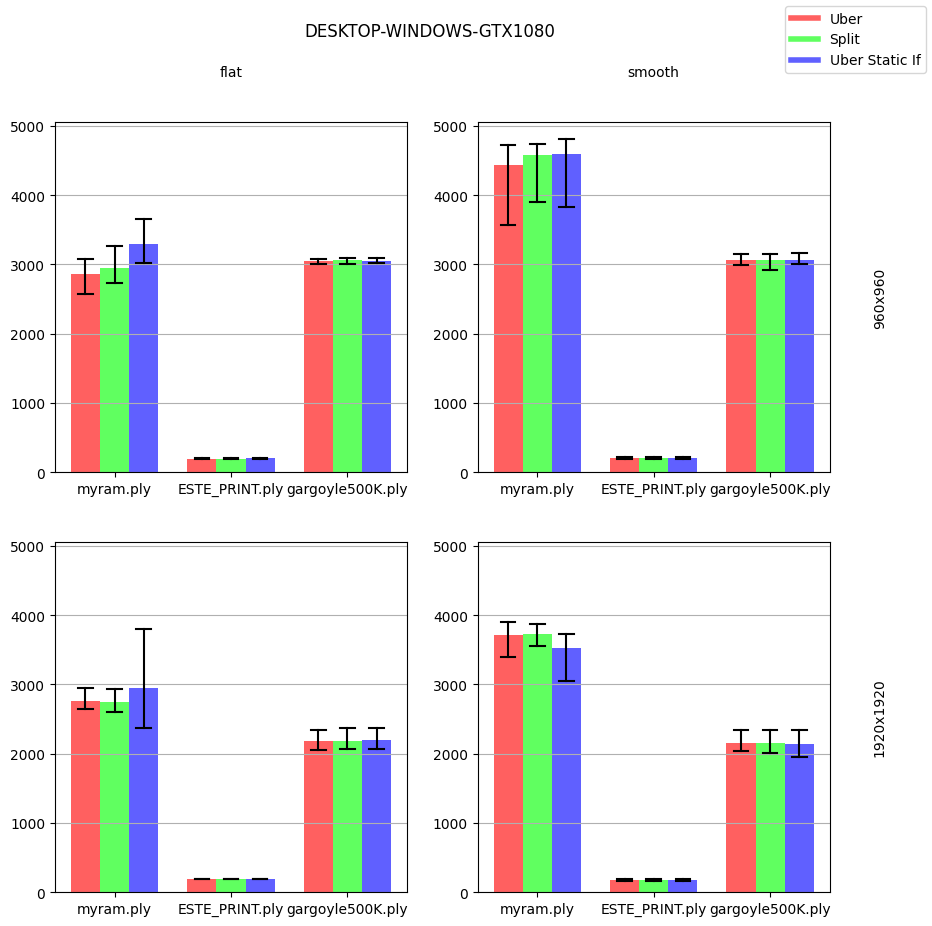

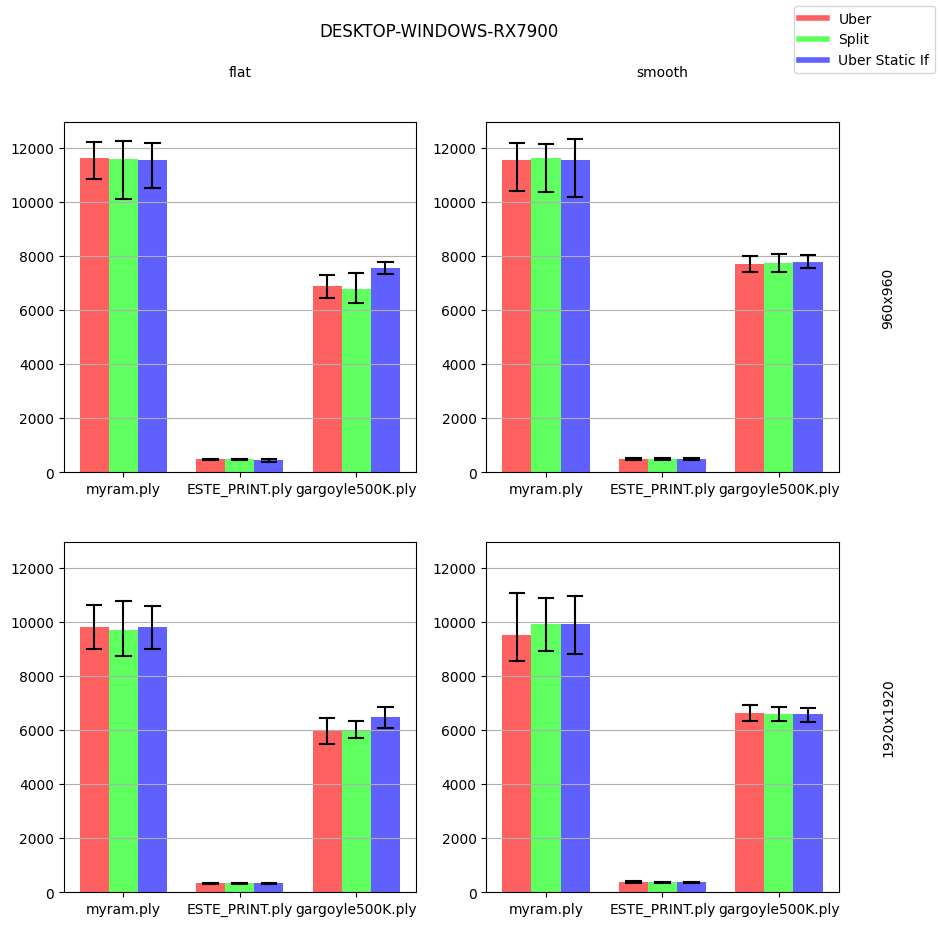

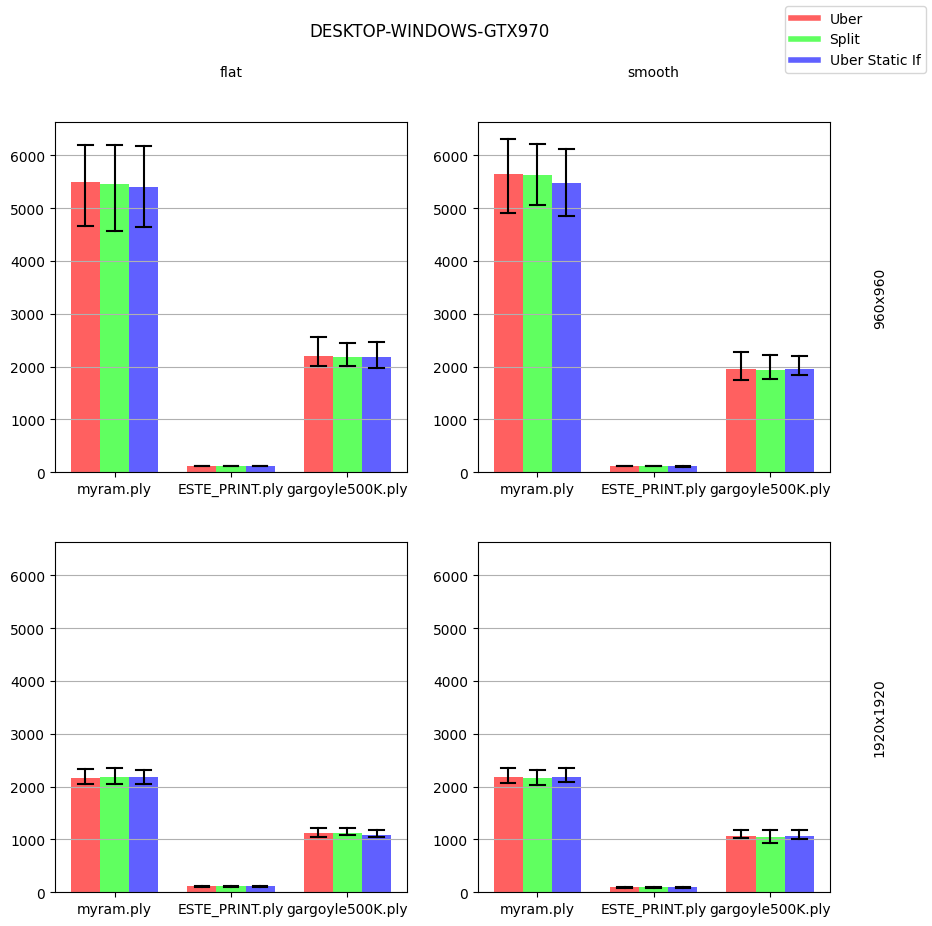

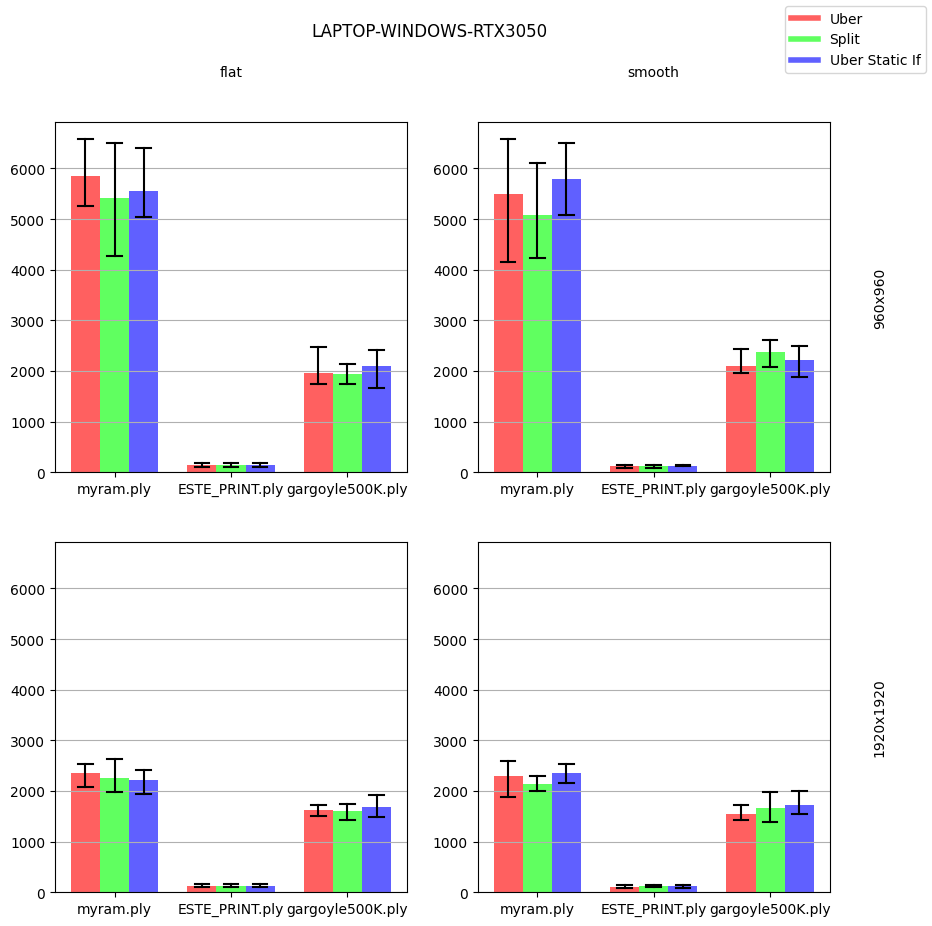

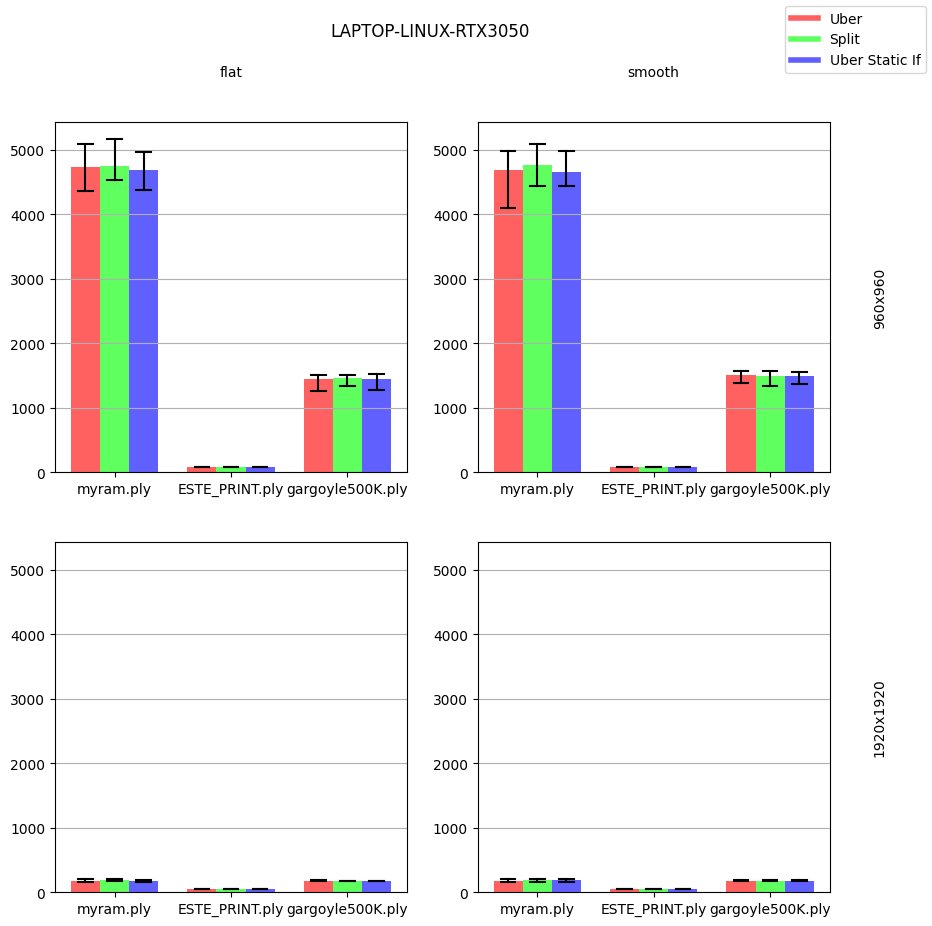

In [10]:
def grouped_hists(
        dataset: pd.DataFrame, 
        device: str, 
        meshes: list[str], 
        resolutions: list[str],
        shadingTypes: list[str],
        starting_x = 10, 
        bar_w = 10, 
        group_dist = 10,
        colors = ["#ff6060","#60ff60","#6060ff"],
        all_same_height = False,
        log = False
    ):
    filtered = dataset[dataset.Device == device]
    fig = plt.figure(figsize=(10,10))
    fig.legend(handles = [plt.Line2D([0],[0],color=colors[0],linewidth=4),plt.Line2D([0],[0],color=colors[1],linewidth=4),plt.Line2D([0],[0],color=colors[2],linewidth=4)],labels = ["Uber", "Split", "Uber Static If"])
    axs = fig.subplots(len(resolutions),len(shadingTypes)).T.flatten().tolist()
    #axs = [axs[0], axs[2], axs[1], axs[3]]
    max_height = 0
    center_bars_dist = group_dist+3*bar_w
    xticks_locs = np.arange(bar_w+starting_x, bar_w+starting_x+center_bars_dist*(len(meshes)-1)+1, center_bars_dist).tolist()
    xticks_labels = meshes.tolist()
    for (i,shad) in enumerate(shadingTypes):
        temp_dat = filtered[filtered.Shading == shad]
        for (j, resolution) in enumerate(resolutions):
            current_x = starting_x
            ax: plt.Axes = axs[i*2+j]
            ax.set_xticks(xticks_locs)
            ax.set_xticklabels(xticks_labels)
            tempp = temp_dat[temp_dat.Resolution == resolution]
            for mesh in meshes:
                temp_dat2 = tempp[tempp.Mesh == mesh]
                for (k, splits) in enumerate(["uber", "split", "uber_static_if"]):
                    temp_dat3 = temp_dat2[temp_dat2.Splitting == splits]
                    arr = [x for y in temp_dat3["Framerates"].to_numpy().flatten() for x in y]
                    mn = np.min(arr)
                    mx = np.max(arr)
                    bar_h = np.mean(arr)
                    max_height = max([max_height, np.max(arr)])
                    ax.bar(current_x, bar_h, 10, color=colors[k], log=log)
                    ax.plot([current_x, current_x],[mx, mn], color="#000000")
                    ax.plot([current_x-bar_w/4,current_x+bar_w/4],[mx, mx], color="#000000")
                    ax.plot([current_x-bar_w/4,current_x+bar_w/4],[mn, mn], color="#000000")
                    ax.grid(True, axis="y", which="both")
                    current_x += bar_w
                current_x += group_dist
    if all_same_height:
        for ax in axs:
            ax.set_ybound(upper = 1.05*max_height)
    for (i, shad) in enumerate(shadingTypes):
        x0, y0, w0, h0 = axs[2*i].get_position().bounds
        text_x = x0 + w0/2
        text_y = y0 + h0 + 0.05
        fig.text(text_x, text_y, shad, ha="center", va="center")
    for (i, res) in enumerate(resolutions):
        x0, y0, w0, h0 = axs[i+(len(axs)-len(resolutions))].get_position().bounds
        text_x = x0 + w0 + 0.05
        text_y = y0 + h0/2
        fig.text(text_x, text_y, res, ha="center", va="center", rotation = "vertical")
    fig.suptitle(device)
    plt.show()

for device in dat["Device"].unique():
    grouped_hists(dat, device, dat["Mesh"].unique(), dat["Resolution"].unique(), dat["Shading"].unique(), log=False, all_same_height=True)
    

In [11]:
dat2 = pd.read_json("./test_results_varying.json")
print(dat2)

                      Device            Mesh       Splitting  Shading  \
0    Windows-NVIDIA-GTX-1080       myram.ply            uber  varying   
1    Windows-NVIDIA-GTX-1080       myram.ply            uber  varying   
2    Windows-NVIDIA-GTX-1080       myram.ply           split  varying   
3    Windows-NVIDIA-GTX-1080       myram.ply           split  varying   
4    Windows-NVIDIA-GTX-1080       myram.ply  uber_static_if  varying   
..                       ...             ...             ...      ...   
139  Windows-AMD-RX-7900-XTX  ESTE_PRINT.ply            uber  varying   
140  Windows-AMD-RX-7900-XTX  ESTE_PRINT.ply           split  varying   
141  Windows-AMD-RX-7900-XTX  ESTE_PRINT.ply           split  varying   
142  Windows-AMD-RX-7900-XTX  ESTE_PRINT.ply  uber_static_if  varying   
143  Windows-AMD-RX-7900-XTX  ESTE_PRINT.ply  uber_static_if  varying   

    Coloring Resolution                                         Framerates  
0    varying    960x960  [3743.075, 3742.403, 

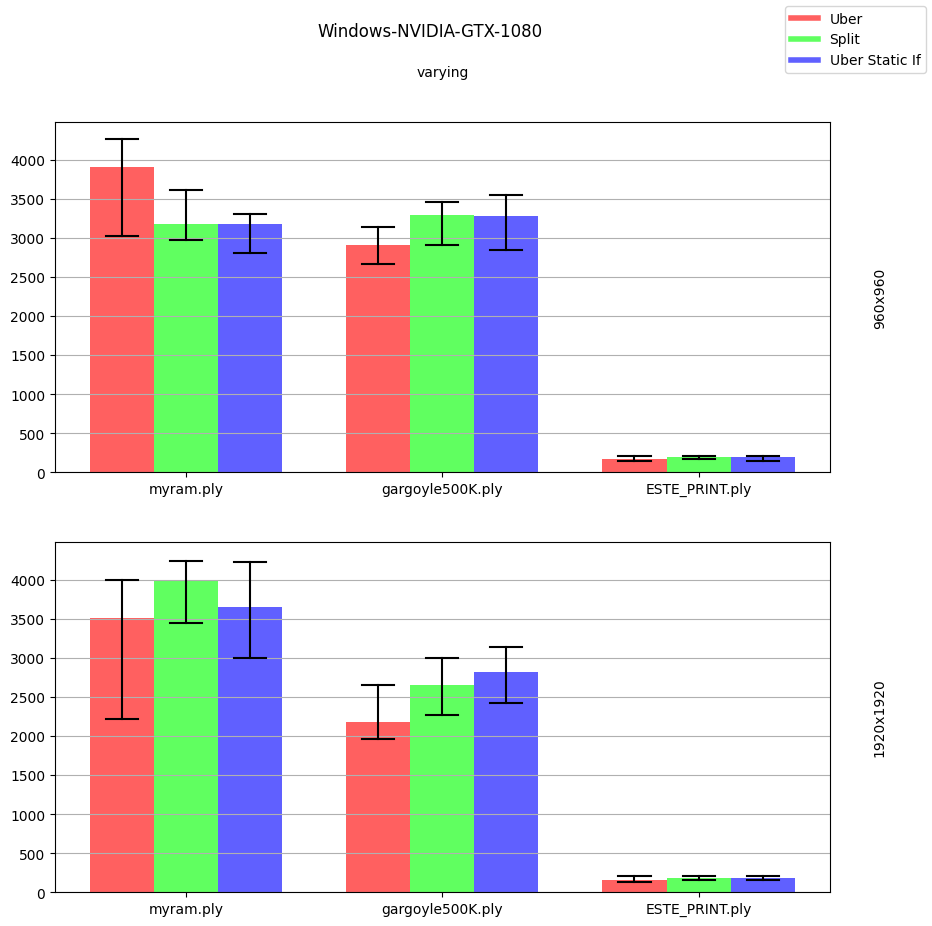

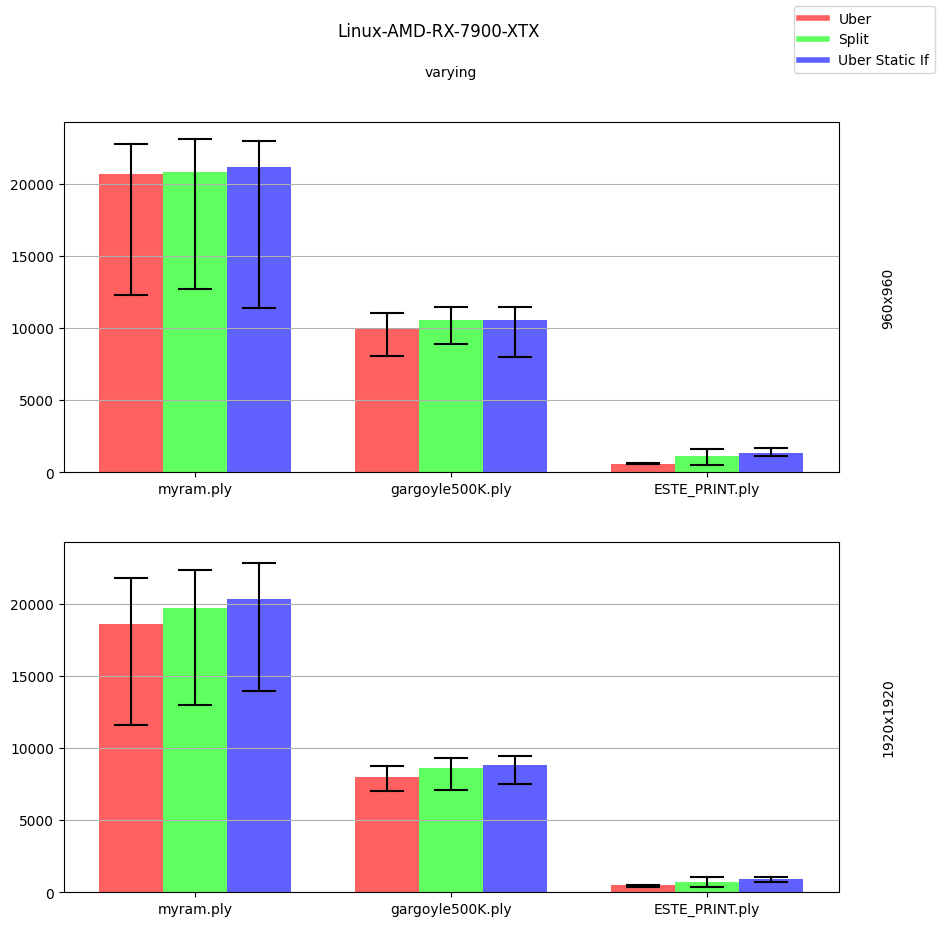

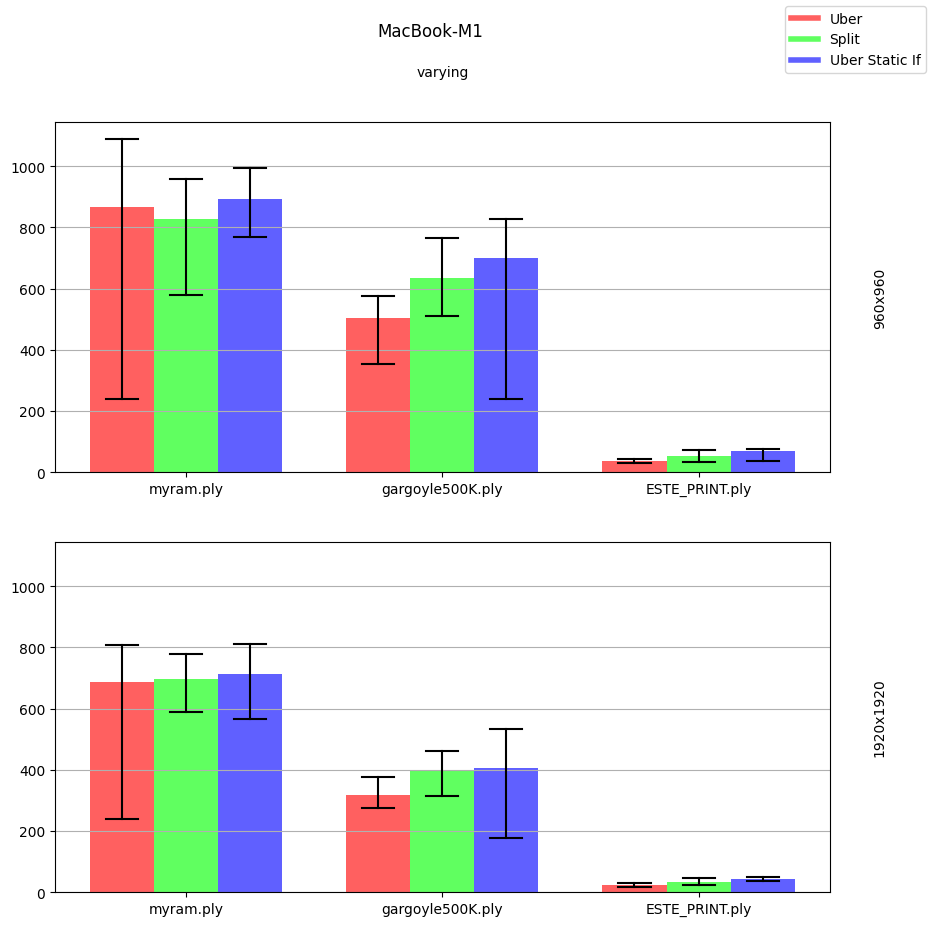

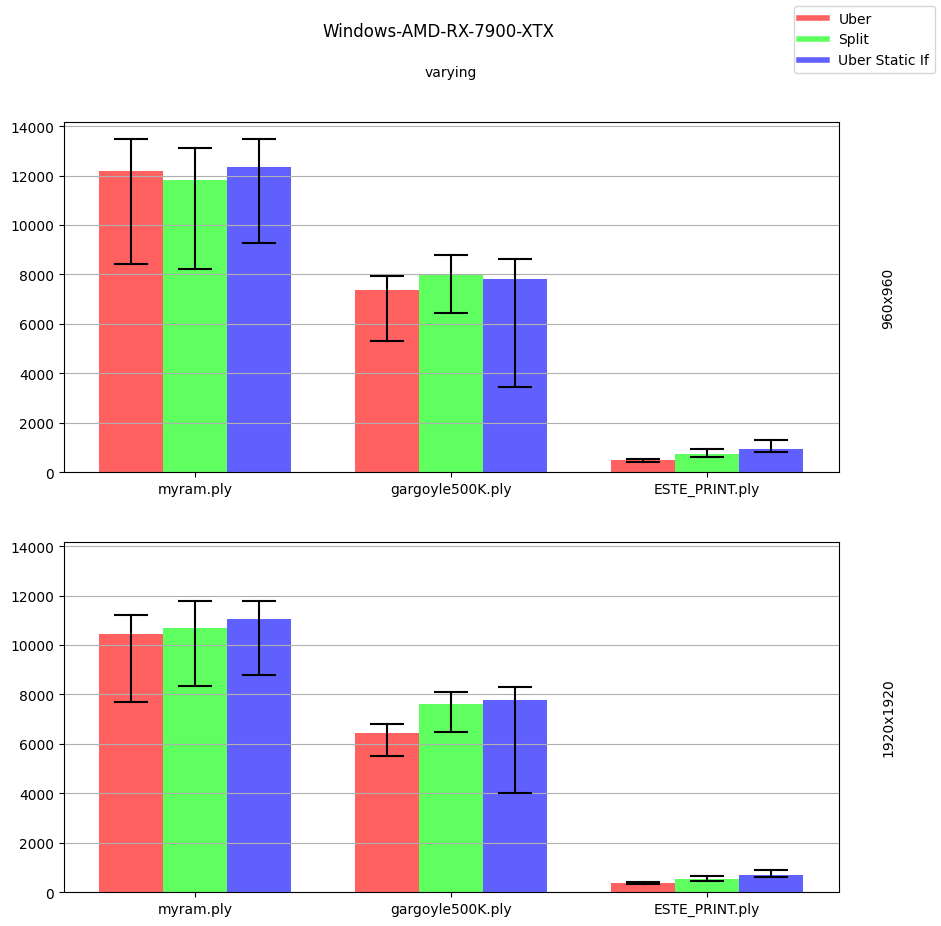

In [12]:
for device in dat2["Device"].unique():
    grouped_hists(dat2, device, dat2["Mesh"].unique(), dat2["Resolution"].unique(), dat2["Shading"].unique(), log=False, all_same_height=True)